# Transfer learning (TL)
-- is a technique in machine learning (ML) in which knowledge learned from a task is re-used in order to boost performance on a related task. For example, for image classification, knowledge gained while learning to recognize cars could be applied when trying to recognize trucks.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [10]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [13]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [14]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

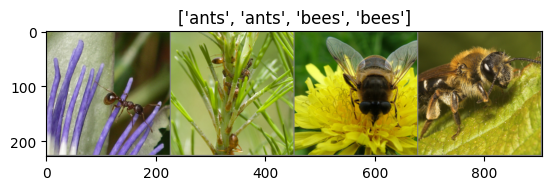

In [16]:
imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### Finetuning the convnet ####

Load a pretrained model and reset final fully connected layer.

In [18]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\klikh/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [19]:
#observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

- StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
- Decay LR by a factor of 0.1 every 7 epochs
- Learning rate scheduling should be applied after optimizer’s update
e.g., you should write your code this way:
- for epoch in range(100):

 train(...)

validate(...)

 scheduler.step()

In [20]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6782 Acc: 0.5615
val Loss: 0.5381 Acc: 0.7124

Epoch 1/24
----------
train Loss: 0.5446 Acc: 0.7459
val Loss: 0.3980 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5001 Acc: 0.7787
val Loss: 0.3154 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4173 Acc: 0.8361
val Loss: 0.2554 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3899 Acc: 0.8156
val Loss: 0.2383 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.3892 Acc: 0.8320
val Loss: 0.2280 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3497 Acc: 0.8525
val Loss: 0.1943 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3265 Acc: 0.8689
val Loss: 0.2001 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3082 Acc: 0.8934
val Loss: 0.2031 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3308 Acc: 0.8648
val Loss: 0.2027 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3429 Acc: 0.8320
val Loss: 0.2132 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3499 Acc: 0.8279
val Loss: 0.1931 Acc: 0.9542

Ep

#### ConvNet as fixed feature extractor ####
- Here, we need to freeze all the network except the final layer.
- We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


- Observe that only parameters of final layer are being optimized as
- opposed to before.

In [23]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [24]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5552 Acc: 0.7008
val Loss: 0.3825 Acc: 0.7712

Epoch 1/24
----------
train Loss: 0.3953 Acc: 0.8074
val Loss: 0.2037 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.6115 Acc: 0.7295
val Loss: 0.2354 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5922 Acc: 0.7705
val Loss: 0.2073 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4521 Acc: 0.7992
val Loss: 0.2969 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5732 Acc: 0.7705
val Loss: 0.2112 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5368 Acc: 0.7664
val Loss: 0.1917 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4134 Acc: 0.8074
val Loss: 0.2133 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3515 Acc: 0.8320
val Loss: 0.2007 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3268 Acc: 0.8525
val Loss: 0.2223 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3301 Acc: 0.8607
val Loss: 0.1938 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4020 Acc: 0.8361
val Loss: 0.1902 Acc: 0.9542

Ep